In [18]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Ruta de la carpeta que contiene las imágenes
ruta_carpeta = "/Users/yerzyddavidalconbustos/Library/CloudStorage/OneDrive-EscuelaMilitardeIngenieria/DEVELOPER/yerzyd/UPB/DL/dl/TRABAJO FINAL AGUA BLANCA/IMG"

# Función para la ecualización del histograma en el canal V del espacio de color HSV
def ecualizar_histograma(imagen):
    """Ecualiza el histograma de la imagen en el canal V."""
    imagen_hsv = cv2.cvtColor(imagen, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(imagen_hsv)
    v_ecualizado = cv2.equalizeHist(v)
    imagen_hsv_ecualizada = cv2.merge((h, s, v_ecualizado))
    return cv2.cvtColor(imagen_hsv_ecualizada, cv2.COLOR_HSV2BGR)

def segmentar_zonas_verdes(imagen):
    """Segmenta las zonas verdes de la imagen utilizando un rango de color HSV."""
    imagen_hsv = cv2.cvtColor(imagen, cv2.COLOR_BGR2HSV)
    
    # Rango de color verde en el espacio HSV
    verde_bajo = np.array([35, 50, 0])
    verde_alto = np.array([85, 255, 255])
    
    # Crear máscara para incluir solo colores verdes
    mascara_verde = cv2.inRange(imagen_hsv, verde_bajo, verde_alto)
    
    # Reducción de ruido con operaciones morfológicas
    kernel = np.ones((5, 5), np.uint8)
    mascara_verde = cv2.morphologyEx(mascara_verde, cv2.MORPH_CLOSE, kernel)
    mascara_verde = cv2.morphologyEx(mascara_verde, cv2.MORPH_OPEN, kernel)
    
    return mascara_verde

# Listas para almacenar las imágenes originales y segmentadas
imagenes_originales = []
imagenes_segmentadas = []

# Guardar imágenes segmentadas
for archivo in os.listdir(ruta_carpeta):
    ruta_archivo = os.path.join(ruta_carpeta, archivo)
    
    if os.path.isfile(ruta_archivo) and archivo.lower().endswith(('.png', '.jpg', '.jpeg')):
        # Leer y redimensionar la imagen a 224x224 píxeles
        imagen = cv2.imread(ruta_archivo)
        imagen = cv2.resize(imagen, (5472, 3648))

        # Aplicar ecualización de histograma y segmentación de zonas verdes
        imagen_ecualizada = ecualizar_histograma(imagen)
        mascara_verde = segmentar_zonas_verdes(imagen_ecualizada)

        # Añadir las imágenes al listado correspondiente
        imagenes_originales.append(imagen_ecualizada)
        imagenes_segmentadas.append(mascara_verde)

print("Cantidad de imágenes segmentadas:", len(imagenes_segmentadas))


Cantidad de imágenes segmentadas: 1049


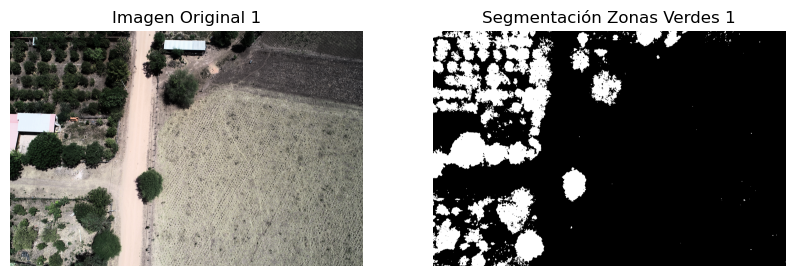

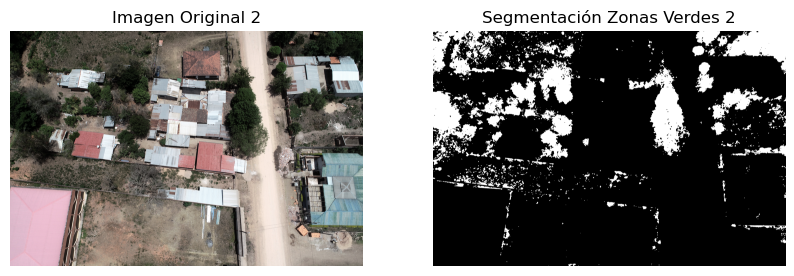

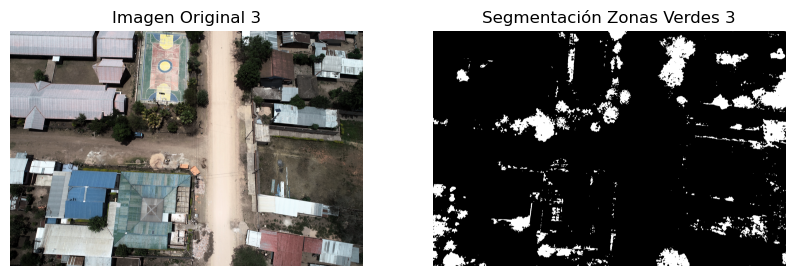

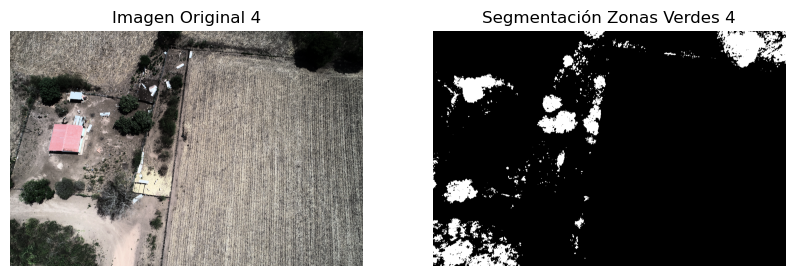

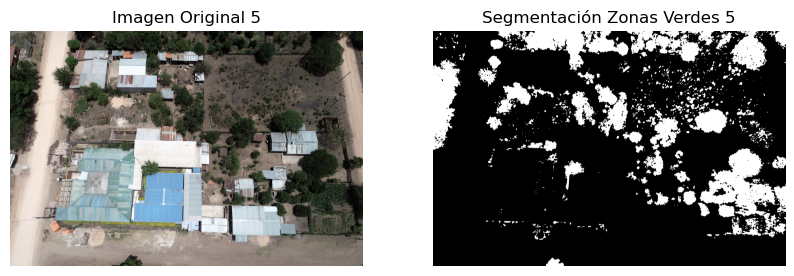

In [19]:
# Visualizar solo las primeras 5 imágenes originales y sus segmentaciones
for i in range(5):
    plt.figure(figsize=(10, 5))

    # Mostrar imagen original
    plt.subplot(1, 2, 1)
    plt.title(f"Imagen Original {i + 1}")
    plt.imshow(cv2.cvtColor(imagenes_originales[i], cv2.COLOR_BGR2RGB))  # Convertir BGR a RGB
    plt.axis('off')  # Ocultar ejes

    # Mostrar segmentación
    plt.subplot(1, 2, 2)
    plt.title(f"Segmentación Zonas Verdes {i + 1}")
    plt.imshow(imagenes_segmentadas[i], cmap='gray')  # Mostrar en escala de grises
    plt.axis('off')  # Ocultar ejes

    plt.show()


In [4]:
# Lista para almacenar la proporción de píxeles verdes en cada imagen
proporcion_verdes = []

# Calcular la proporción de píxeles verdes en cada imagen segmentada
for mascara in imagenes_segmentadas:
    total_pixeles = 5472 * 3648  # Total de píxeles en la imagen
    pixeles_verdes = np.sum(mascara > 0)  # Sumar los píxeles verdes (valores distintos de cero)
    proporcion = pixeles_verdes / total_pixeles  # Calcular la proporción de píxeles verdes
    proporcion_verdes.append(proporcion)  # Almacenar la proporción

# Verificación: Mostrar la proporción de píxeles verdes para cada imagen
for i, prop in enumerate(proporcion_verdes):
    print(f"Imagen {i + 1}: {prop:.2f} de píxeles verdes")


Imagen 1: 0.17 de píxeles verdes
Imagen 2: 0.16 de píxeles verdes
Imagen 3: 0.10 de píxeles verdes
Imagen 4: 0.08 de píxeles verdes
Imagen 5: 0.20 de píxeles verdes
Imagen 6: 0.06 de píxeles verdes
Imagen 7: 0.29 de píxeles verdes
Imagen 8: 0.27 de píxeles verdes
Imagen 9: 0.33 de píxeles verdes
Imagen 10: 0.11 de píxeles verdes
Imagen 11: 0.34 de píxeles verdes
Imagen 12: 0.24 de píxeles verdes
Imagen 13: 0.10 de píxeles verdes
Imagen 14: 0.21 de píxeles verdes
Imagen 15: 0.13 de píxeles verdes
Imagen 16: 0.31 de píxeles verdes
Imagen 17: 0.20 de píxeles verdes
Imagen 18: 0.41 de píxeles verdes
Imagen 19: 0.36 de píxeles verdes
Imagen 20: 0.05 de píxeles verdes
Imagen 21: 0.17 de píxeles verdes
Imagen 22: 0.42 de píxeles verdes
Imagen 23: 0.30 de píxeles verdes
Imagen 24: 0.22 de píxeles verdes
Imagen 25: 0.29 de píxeles verdes
Imagen 26: 0.12 de píxeles verdes
Imagen 27: 0.17 de píxeles verdes
Imagen 28: 0.36 de píxeles verdes
Imagen 29: 0.16 de píxeles verdes
Imagen 30: 0.05 de píxe

In [5]:
def clasificar_cobertura(proporcion):
    """
    Clasifica la cobertura de zonas verdes basada en la proporción de píxeles verdes.

    Parámetros:
    proporcion (float): Proporción de píxeles verdes en la imagen.

    Retorna:
    str: Clasificación de la cobertura ("Mínima", "Baja", "Moderada", "Alta").
    """
    # Validación del tipo de dato
    if not isinstance(proporcion, (int, float)):
        raise ValueError("La proporción debe ser un número (int o float).")
    
    # Clasificación según la proporción de píxeles verdes
    if proporcion < 0.15:
        return "Mínima"  # Presencia de zonas verdes mínima
    elif 0.15 <= proporcion < 0.30:
        return "Baja"  # Presencia de zonas verdes baja
    elif 0.30 <= proporcion < 0.50:
        return "Moderada"  # Presencia de zonas verdes moderada
    else:
        return "Alta"  # Presencia de zonas verdes alta (0.50 o más)


In [27]:
# Crear la matriz de clasificación
matriz_clasificacion = [[clasificar_cobertura(proporcion), proporcion] for proporcion in proporcion_verdes]

# Comprobar datos
print("Resultados de clasificación:")
for i, (categoria, proporcion) in enumerate(matriz_clasificacion):
    print(f"Imagen {i + 1}: Categoría: {categoria}, Proporción: {proporcion:.2f}")


Resultados de clasificación:
Imagen 1: Categoría: Baja, Proporción: 0.17
Imagen 2: Categoría: Baja, Proporción: 0.16
Imagen 3: Categoría: Mínima, Proporción: 0.10
Imagen 4: Categoría: Mínima, Proporción: 0.08
Imagen 5: Categoría: Baja, Proporción: 0.20
Imagen 6: Categoría: Mínima, Proporción: 0.06
Imagen 7: Categoría: Baja, Proporción: 0.29
Imagen 8: Categoría: Baja, Proporción: 0.27
Imagen 9: Categoría: Moderada, Proporción: 0.33
Imagen 10: Categoría: Mínima, Proporción: 0.11
Imagen 11: Categoría: Moderada, Proporción: 0.34
Imagen 12: Categoría: Baja, Proporción: 0.24
Imagen 13: Categoría: Mínima, Proporción: 0.10
Imagen 14: Categoría: Baja, Proporción: 0.21
Imagen 15: Categoría: Mínima, Proporción: 0.13
Imagen 16: Categoría: Moderada, Proporción: 0.31
Imagen 17: Categoría: Baja, Proporción: 0.20
Imagen 18: Categoría: Moderada, Proporción: 0.41
Imagen 19: Categoría: Moderada, Proporción: 0.36
Imagen 20: Categoría: Mínima, Proporción: 0.05
Imagen 21: Categoría: Baja, Proporción: 0.17
I

In [28]:
import pandas as pd
from pathlib import Path

# Crear un DataFrame a partir de la matriz de clasificación
df = pd.DataFrame(matriz_clasificacion, columns=['Categoría de Cobertura Vegetal', 'Proporción de Verde'])

# Definir el nombre del archivo y la ruta
nombre_archivo = Path("clasificacion_cobertura_vegetal.xlsx")

# Exportar el DataFrame a un archivo Excel
df.to_excel(nombre_archivo, index=False)

# Mensaje de éxito
print(f"Archivo '{nombre_archivo.name}' exportado con éxito en la ubicación: {nombre_archivo.resolve()}")

Archivo 'clasificacion_cobertura_vegetal.xlsx' exportado con éxito en la ubicación: /Users/yerzyddavidalconbustos/Library/CloudStorage/OneDrive-EscuelaMilitardeIngenieria/DEVELOPER/yerzyd/UPB/DL/dl/TRABAJO FINAL AGUA BLANCA/clasificacion_cobertura_vegetal.xlsx


In [29]:
import pandas as pd
from pathlib import Path

# Definir la ruta del archivo
ruta_archivo = Path('/Users/yerzyddavidalconbustos/Library/CloudStorage/OneDrive-EscuelaMilitardeIngenieria/DEVELOPER/yerzyd/UPB/DL/dl/TRABAJO FINAL AGUA BLANCA/clasificacion_cobertura_vegetal.xlsx')

# Intentar leer el archivo Excel
try:
    df = pd.read_excel(ruta_archivo)
except FileNotFoundError:
    print(f"Error: El archivo '{ruta_archivo}' no fue encontrado.")
    raise
except Exception as e:
    print(f"Error al leer el archivo: {e}")
    raise

# Mapeo de categorías textuales a números enteros
categoria_a_numero = {
    "Mínima": 0,
    "Baja": 1,
    "Moderada": 2,
    "Alta": 3
}

# Aplicar el mapeo para obtener las categorías codificadas
df['Categoría Codificada'] = df['Categoría de Cobertura Vegetal'].map(categoria_a_numero)

# Crear la matriz resultante con las columnas deseadas
matriz_resultante = df[['Categoría Codificada', 'Proporción de Verde']]

# Comprobación del modelo
print(matriz_resultante.head(100))

# Guardar la matriz resultante en un nuevo archivo Excel
nombre_archivo_resultante = Path('matriz_codificada.xlsx')
matriz_resultante.to_excel(nombre_archivo_resultante, index=False)

print(f"Archivo '{nombre_archivo_resultante.name}' exportado con éxito en la ubicación: {nombre_archivo_resultante.resolve()}")


    Categoría Codificada  Proporción de Verde
0                      1             0.168159
1                      1             0.155393
2                      0             0.097500
3                      0             0.082082
4                      1             0.196212
..                   ...                  ...
95                     1             0.261916
96                     0             0.026468
97                     1             0.185048
98                     1             0.168330
99                     1             0.178069

[100 rows x 2 columns]
Archivo 'matriz_codificada.xlsx' exportado con éxito en la ubicación: /Users/yerzyddavidalconbustos/Library/CloudStorage/OneDrive-EscuelaMilitardeIngenieria/DEVELOPER/yerzyd/UPB/DL/dl/TRABAJO FINAL AGUA BLANCA/matriz_codificada.xlsx


In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Asegúrate de que no hay valores nulos en la matriz resultante
if matriz_resultante.isnull().values.any():
    print("Advertencia: Hay valores nulos en los datos.")

# Calcular el tamaño total de los datos
total_rows = len(matriz_resultante)
print(f"Tamaño total de los datos: {total_rows}")

# Dividir los datos en entrenamiento y prueba (70% entrenamiento, 30% prueba)
train_data, test_data = train_test_split(matriz_resultante, test_size=0.3, random_state=42)

# Extraer características y etiquetas
x_train = train_data['Proporción de Verde'].values.reshape(-1, 1)
y_train = to_categorical(train_data['Categoría Codificada'].values, num_classes=4)

x_test = test_data['Proporción de Verde'].values.reshape(-1, 1)
y_test = to_categorical(test_data['Categoría Codificada'].values, num_classes=4)

# Imprimir tamaño de los datos
print("Tamaño del conjunto de entrenamiento:", train_data.shape)
print("Tamaño del conjunto de prueba:", test_data.shape)

# Verificación de los datos
print("\nDatos de entrenamiento:")
print(train_data.head())
print("\nDatos de prueba:")
print(test_data.head(30))

# Imprimir las formas de las matrices de características y etiquetas
print("\nForma de x_train:", x_train.shape)  # Debe ser (número de ejemplos, número de características)
print("Forma de y_train:", y_train.shape)  # Debe ser (número de ejemplos, número de clases)
print("Forma de x_test:", x_test.shape)     # Debe ser (número de ejemplos, número de características)
print("Forma de y_test:", y_test.shape)     # Debe ser (número de ejemplos, número de clases)


Tamaño total de los datos: 1049
Tamaño del conjunto de entrenamiento: (734, 2)
Tamaño del conjunto de prueba: (315, 2)

Datos de entrenamiento:
     Categoría Codificada  Proporción de Verde
281                     2             0.462110
266                     0             0.110631
497                     1             0.251722
613                     1             0.179619
836                     0             0.098029

Datos de prueba:
     Categoría Codificada  Proporción de Verde
352                     3             0.790692
985                     3             0.503142
877                     2             0.473764
983                     2             0.303419
31                      0             0.087788
448                     0             0.132730
198                     0             0.056561
424                     2             0.408550
107                     1             0.221433
713                     1             0.292482
551                     2             0

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Forma de x_train: (734, 1)
Forma de y_train: (734, 4)
Epoch 1/130
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.2790 - loss: 1.3591 - val_accuracy: 0.4694 - val_loss: 1.2346
Epoch 2/130
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3919 - loss: 1.2328 - val_accuracy: 0.4694 - val_loss: 1.0657
Epoch 3/130
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3304 - loss: 1.1636 - val_accuracy: 0.4694 - val_loss: 0.9554
Epoch 4/130
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4714 - loss: 0.9945 - val_accuracy: 0.7075 - val_loss: 0.8929
Epoch 5/130
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6282 - loss: 0.9929 - val_accuracy: 0.8027 - val_loss: 0.8244
Epoch 6/130
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6983 - loss: 0.9411 - val_accuracy: 0.8095 - val_loss: 0.7491
Epoch 7/130
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7538 - loss: 0.8846 - val_accuracy: 0.7687 - val_loss: 0.6680
Epoch 8/130
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/ste

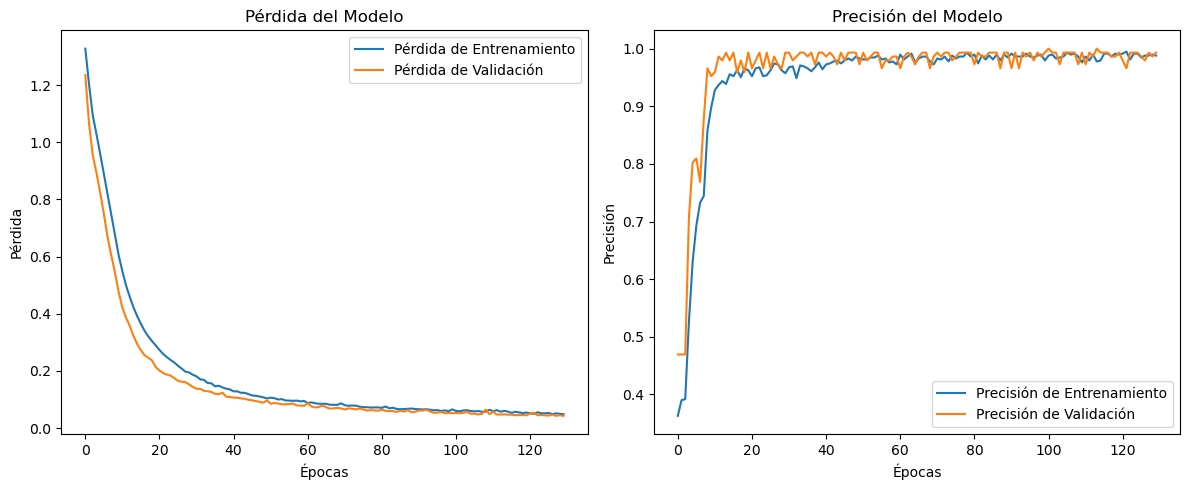

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Crear el modelo
model = Sequential()
model.add(Dense(50, input_dim=x_train.shape[1], activation='relu'))  # Capa de entrada
model.add(Dense(30, activation='relu'))  # Capa oculta
model.add(Dense(4, activation='softmax'))  # Capa de salida

# Compilar el modelo
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Imprimir las formas de entrada y salida
print("Forma de x_train:", x_train.shape)
print("Forma de y_train:", y_train.shape)

# Definir el callback de EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Dividir los datos de entrenamiento para la validación
x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)

# Entrenar el modelo
history = model.fit(
    x_train_split, 
    y_train_split, 
    validation_data=(x_val_split, y_val_split),
    epochs=130, 
    batch_size=10,
    callbacks=[early_stopping]
)

# Visualizar la pérdida y precisión del modelo
plt.figure(figsize=(12, 5))

# Gráfico de pérdida
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.title('Pérdida del Modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Gráfico de precisión
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Precisión de Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de Validación')
plt.title('Precisión del Modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.tight_layout()
plt.show()


NTERPRETACIÓN DE DATOS

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Matriz de Confusión:
[[ 61   1   0   0]
 [  0 116   0   0]
 [  0   3 123   0]
 [  0   0   5   6]]


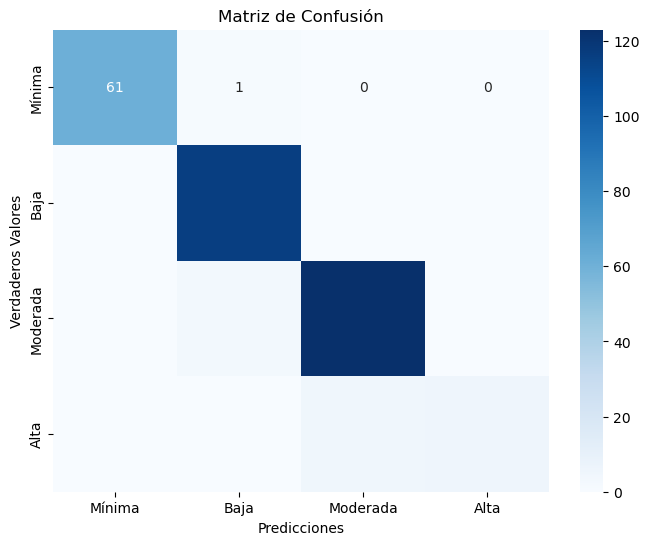

Verdaderos Positivos (TP): [ 61 116 123   6]
Falsos Positivos (FP): [0 4 5 0]
Falsos Negativos (FN): [1 0 3 5]
Verdaderos Negativos (TN): [253 195 184 304]
Reporte de Clasificación:
              precision    recall  f1-score   support

      Mínima       1.00      0.98      0.99        62
        Baja       0.97      1.00      0.98       116
    Moderada       0.96      0.98      0.97       126
        Alta       1.00      0.55      0.71        11

    accuracy                           0.97       315
   macro avg       0.98      0.88      0.91       315
weighted avg       0.97      0.97      0.97       315



In [33]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Imprimir la matriz de confusión
print("Matriz de Confusión:")
print(conf_matrix)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Mínima', 'Baja', 'Moderada', 'Alta'], 
            yticklabels=['Mínima', 'Baja', 'Moderada', 'Alta'])
plt.ylabel('Verdaderos Valores')
plt.xlabel('Predicciones')
plt.title('Matriz de Confusión')
plt.show()

# Calcular True Positives, False Positives, False Negatives, True Negatives
TP = np.diag(conf_matrix)
FP = conf_matrix.sum(axis=0) - TP
FN = conf_matrix.sum(axis=1) - TP
TN = conf_matrix.sum() - (FP + FN + TP)

print(f"Verdaderos Positivos (TP): {TP}")
print(f"Falsos Positivos (FP): {FP}")
print(f"Falsos Negativos (FN): {FN}")
print(f"Verdaderos Negativos (TN): {TN}")

# Calcular y mostrar el reporte de clasificación
report = classification_report(y_true_classes, y_pred_classes, 
                               target_names=['Mínima', 'Baja', 'Moderada', 'Alta'])
print("Reporte de Clasificación:")
print(report)


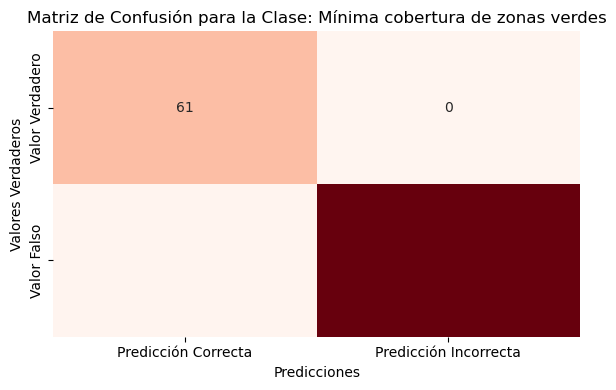

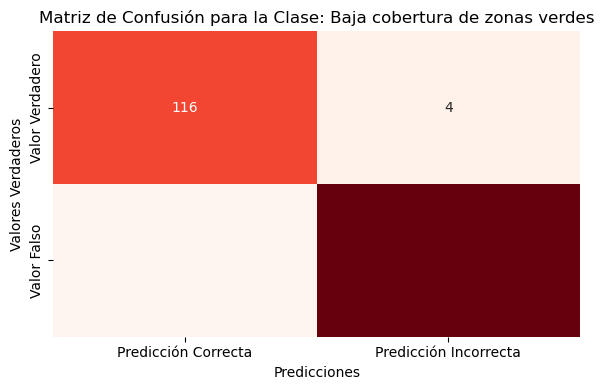

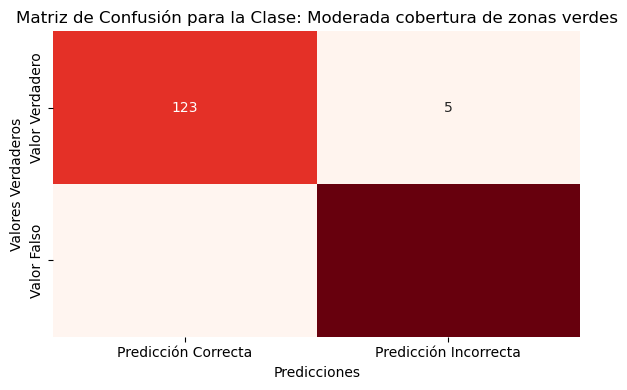

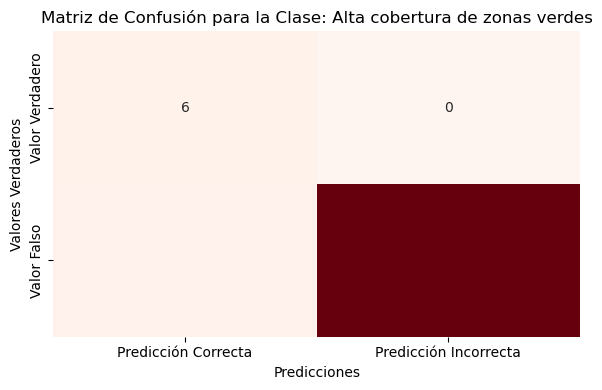

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Función para plotear una matriz de confusión de cada clase
def plot_confusion_matrix_for_class(class_index, TP, FP, FN, TN, class_names):
    # Crear la matriz de confusión para la clase específica
    conf_matrix = np.array([[TP[class_index], FP[class_index]],
                            [FN[class_index], TN[class_index]]])

    fig, ax = plt.subplots(figsize=(6, 4))  # Ajustar el tamaño de la figura
    sns.heatmap(conf_matrix, annot=True, ax=ax, cmap="Reds", fmt="d", cbar=False)

    # Títulos y etiquetas
    ax.set_title(f'Matriz de Confusión para la Clase: {class_names[class_index]}')
    ax.set_xlabel('Predicciones')
    ax.set_ylabel('Valores Verdaderos')
    ax.xaxis.set_ticklabels(['Predicción Correcta', 'Predicción Incorrecta'])
    ax.yaxis.set_ticklabels(['Valor Verdadero', 'Valor Falso'])

    # Mostrar el gráfico
    plt.tight_layout()  # Ajustar la disposición
    plt.show()

# Nombres de las clases
class_names = [
    "Mínima cobertura de zonas verdes",
    "Baja cobertura de zonas verdes",
    "Moderada cobertura de zonas verdes",
    "Alta cobertura de zonas verdes"
]

# Llamado a la función
for i in range(len(TP)): 
    plot_confusion_matrix_for_class(i, TP, FP, FN, TN, class_names)


In [35]:
import pandas as pd

# Función para calcular métricas
def calculate_metrics(TP, FP, FN, TN):
    metrics = {
        'accuracy': (TP + TN) / (TP + TN + FP + FN),
        'precision': TP / (TP + FP) if (TP + FP) > 0 else 0,
        'specificity': TN / (TN + FP) if (TN + FP) > 0 else 0,
        'sensitivity': TP / (TP + FN) if (TP + FN) > 0 else 0,
        'f1_score': 2 * (TP / (TP + FP) * TP / (TP + FN)) / ((TP / (TP + FP) + TP / (TP + FN)) if (TP + FP + FN) > 0 else 1)  # Avoid division by zero
    }
    return metrics

metrics_per_class = []
for i in range(len(TP)):
    metrics = calculate_metrics(TP[i], FP[i], FN[i], TN[i])
    metrics_per_class.append(metrics)
    print(f"Clase {i} - Accuracy: {metrics['accuracy']:.2f}, Precision: {metrics['precision']:.2f}, Especificidad: {metrics['specificity']:.2f}, Sensibilidad: {metrics['sensitivity']:.2f}, F1 Score: {metrics['f1_score']:.2f}")

# Crear un DataFrame para las métricas
df_metrics = pd.DataFrame(metrics_per_class, columns=['accuracy', 'precision', 'specificity', 'sensitivity', 'f1_score'])
df_metrics.index = class_names  # Asignar nombres de clases como índice
print("\nMétricas por clase:")
print(df_metrics)

# Guardar las métricas en un archivo Excel
df_metrics.to_excel('metricas_por_clase.xlsx', index=True)


Clase 0 - Accuracy: 1.00, Precision: 1.00, Especificidad: 1.00, Sensibilidad: 0.98, F1 Score: 0.99
Clase 1 - Accuracy: 0.99, Precision: 0.97, Especificidad: 0.98, Sensibilidad: 1.00, F1 Score: 0.98
Clase 2 - Accuracy: 0.97, Precision: 0.96, Especificidad: 0.97, Sensibilidad: 0.98, F1 Score: 0.97
Clase 3 - Accuracy: 0.98, Precision: 1.00, Especificidad: 1.00, Sensibilidad: 0.55, F1 Score: 0.71

Métricas por clase:
                                    accuracy  precision  specificity  \
Mínima cobertura de zonas verdes    0.996825   1.000000     1.000000   
Baja cobertura de zonas verdes      0.987302   0.966667     0.979899   
Moderada cobertura de zonas verdes  0.974603   0.960938     0.973545   
Alta cobertura de zonas verdes      0.984127   1.000000     1.000000   

                                    sensitivity  f1_score  
Mínima cobertura de zonas verdes       0.983871  0.991870  
Baja cobertura de zonas verdes         1.000000  0.983051  
Moderada cobertura de zonas verdes     0.9

Estadística Descriptiva


In [37]:
# Resumen estadístico descriptivo de la proporción de verde
print("Resumen Estadístico de Proporciones de Verde:")
print(matriz_resultante['Proporción de Verde'].describe())


Resumen Estadístico de Proporciones de Verde:
count    1049.000000
mean        0.268386
std         0.117648
min         0.002219
25%         0.180725
50%         0.275238
75%         0.354619
max         0.790692
Name: Proporción de Verde, dtype: float64


Visualización de Distribución de Proporciones

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


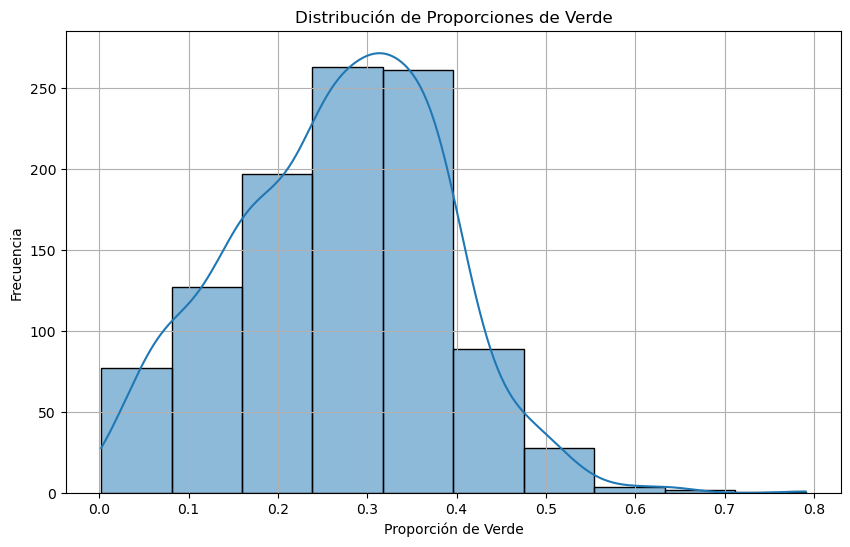

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(matriz_resultante['Proporción de Verde'], bins=10, kde=True)
plt.title('Distribución de Proporciones de Verde')
plt.xlabel('Proporción de Verde')
plt.ylabel('Frecuencia')
plt.grid()
plt.show()


Visualización de Métricas por Clase

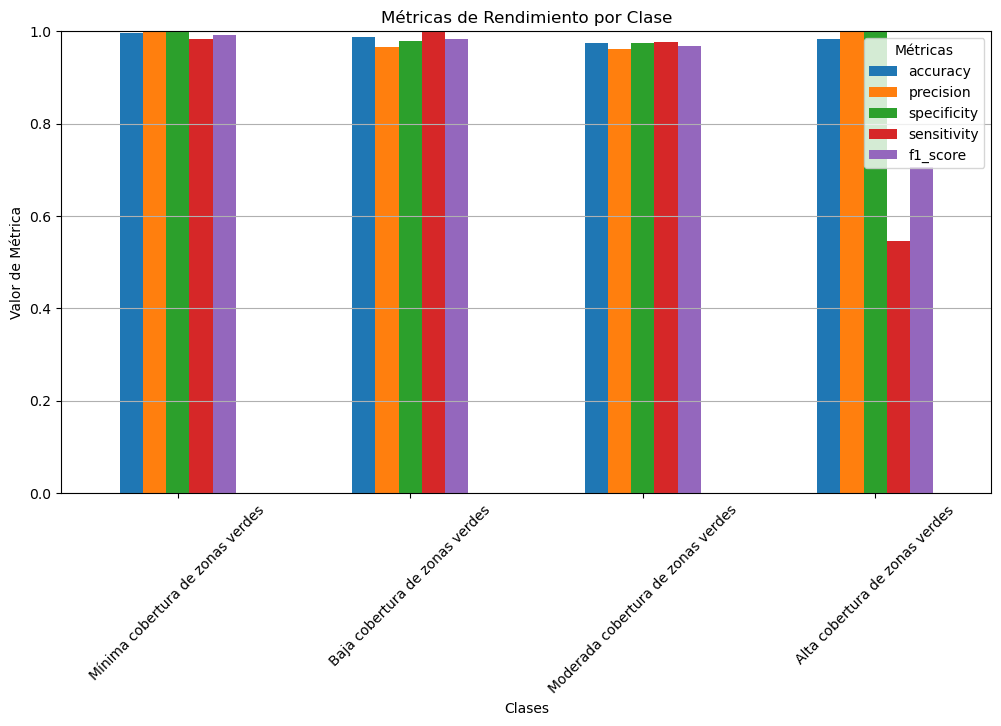

In [39]:
# Visualizar métricas por clase
df_metrics.plot(kind='bar', figsize=(12, 6), ylim=(0, 1), rot=0)
plt.title('Métricas de Rendimiento por Clase')
plt.ylabel('Valor de Métrica')
plt.xlabel('Clases')
plt.grid(axis='y')
plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=45)
plt.legend(title='Métricas')
plt.show()


Matriz de Confusión Normalizada

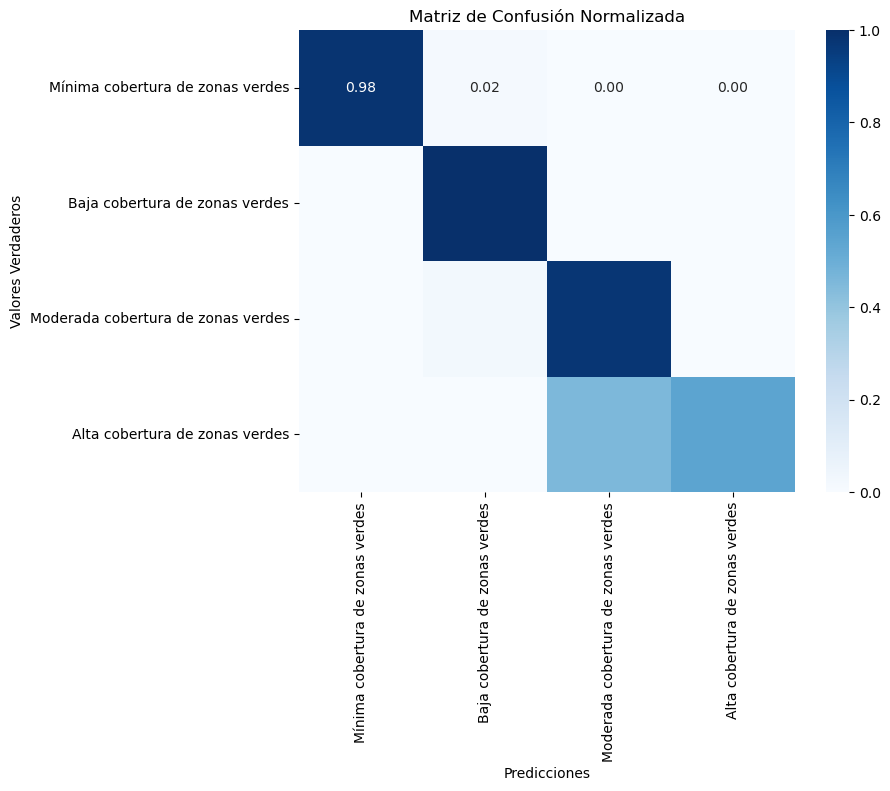

In [40]:
# Normalizar la matriz de confusión
normalized_conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(normalized_conf_matrix, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusión Normalizada')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos')
plt.show()


Boxplot de Proporciones de Verde por Categoría

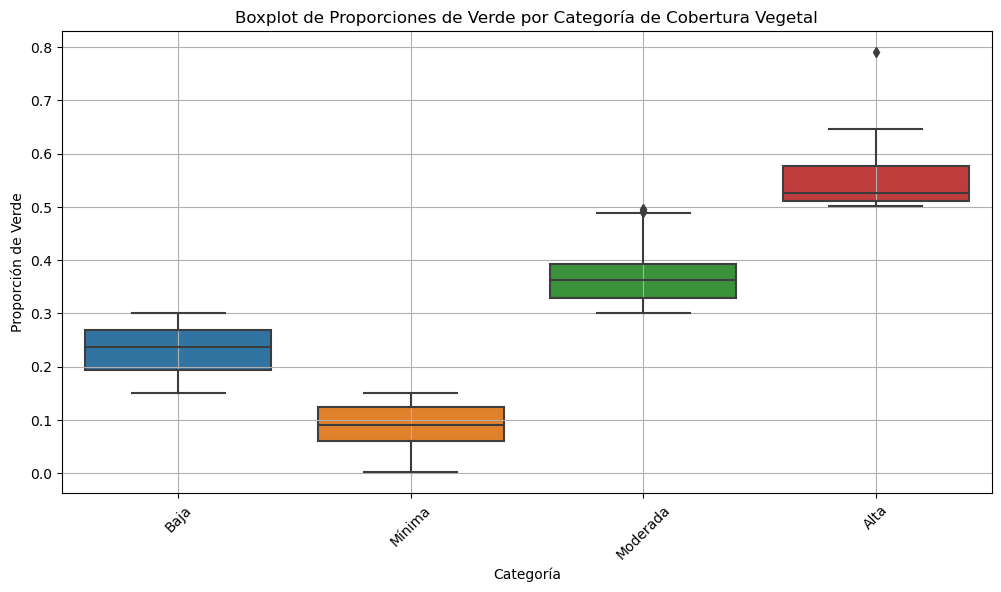

In [41]:
# Añadir la categoría al DataFrame original
matriz_resultante['Categoría'] = df['Categoría de Cobertura Vegetal']

plt.figure(figsize=(12, 6))
sns.boxplot(x='Categoría', y='Proporción de Verde', data=matriz_resultante)
plt.title('Boxplot de Proporciones de Verde por Categoría de Cobertura Vegetal')
plt.xticks(rotation=45)
plt.grid()
plt.show()
